Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Temporal Patterns

This notebook contains the analysis of temporal patterns. Following content is presented:
* a
* Linegraph of ratio of trip starts onto hourly time intervals
* Barplot of ratio of trip starts onto weekdays
* Histogram of density of duration

...ANOVA...

### Imports

In [1]:
import pandas as pd
#pd.options.mode.chained_assignment = None
import glob
import numpy as np
#from numpy import median
#import warnings
#warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style="ticks")
sns.set_theme(style="whitegrid")
#from datetime import datetime

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_prepared_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_prepared_full_{}.csv'.format(mode))
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']
#load data by months
load_monthly_data = False
if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter])

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True
if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter])

In [5]:
# naive fleet sizes
fleet_size_car = len(data_car['id'].unique())
fleet_size_bicycle = len(data_bicycle['id'].unique())
fleet_size_scooter = len(data_scooter['id'].unique())
print("Naive fleet size: {} (cars), {} (bicycles), {} (scooters)".format(fleet_size_car, 
                                                                         fleet_size_bicycle, fleet_size_scooter))

Naive fleet size: 1399 (cars), 2514 (bicycles), 3220 (scooters)


### Temporal Plots

##### Linegraph of trip volume onto date of trip starts

In [23]:
def prepare_data_for_trip_volume_linegraph(data_mode, select_month, month):
        
    plot_data = data_mode.copy()
    if (select_month):
        plot_data = plot_data[plot_data['month']==month]
        
    plot_data = plot_data.rename(columns={"date_start": "Date of trip start"})
    #plot_data['Date of trip start'] = plot_data['date_start']
    plot_data = plot_data.groupby(['Date of trip start','month']).count()
    plot_data['Trip volume'] = plot_data['id']
    plot_data['Utilization'] = plot_data['Trip volume']/fleet_size_car
    plot_data['Mode'] = data_mode['vehicleType'].unique()[0]
    
    return plot_data

    
def plot_trip_volume_linegraph(select_month, month, y_name, show_table):
    plot_data_car = prepare_data_for_trip_volume_linegraph(data_car, select_month, month)
    plot_data_bicycle = prepare_data_for_trip_volume_linegraph(data_bicycle, select_month, month)
    plot_data_scooter = prepare_data_for_trip_volume_linegraph(data_scooter, select_month, month)
    
    plot_data = pd.concat([plot_data_car, plot_data_bicycle, plot_data_scooter])

    plot_data = plot_data[['Mode', 'Trip volume', 'Utilization']]

    ####################
    #INSERT MISSING DATA
    ####################

    plot_data = plot_data.sort_values(['Date of trip start', 'month'])

    g = sns.relplot(x="Date of trip start", y=y_name, kind="line", data=plot_data, hue="Mode", height=10, aspect=2)
    g.fig.autofmt_xdate()
    # show dataframe
    if (show_table):
        print(plot_data.to_string())
    
def plot_trip_volume_by_provider_linegraph(show_table):
    df = data_full.copy()
    df = df.rename(columns={"date_start": "Date of trip start"})

    df = df.groupby(['Date of trip start', 'provider']).count()
    df['Trip volume'] = df['id']
    df = df[['Trip volume']]

    df = df.sort_values(['Date of trip start', 'provider'])

    g = sns.relplot(x="Date of trip start", y="Trip volume", kind="line", data=df, hue="provider", height=10, aspect=2)
    g.fig.autofmt_xdate()
    # show dataframe
    if (show_table):
        print(df.to_string())

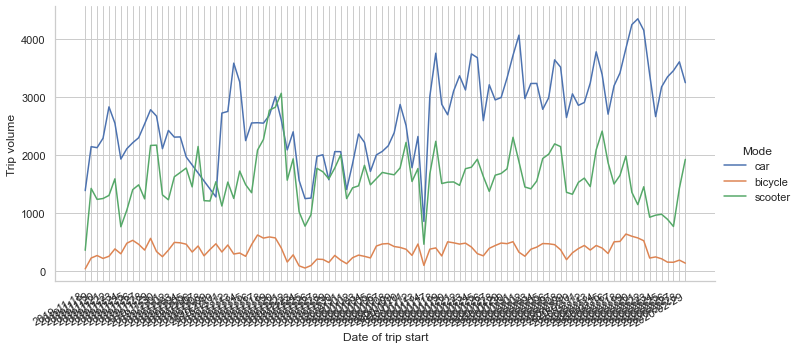

In [24]:
#plot_trip_volume_linegraph(select_month, month, y_name, show_table)
plot_trip_volume_linegraph(False, 12, 'Trip volume', False)

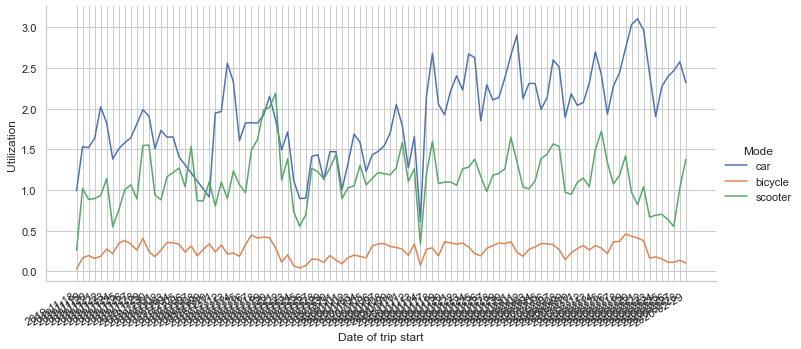

In [25]:
#plot_trip_volume_linegraph(select_month, month, y_name, show_table)
plot_trip_volume_linegraph(False, 12, 'Utilization', False)

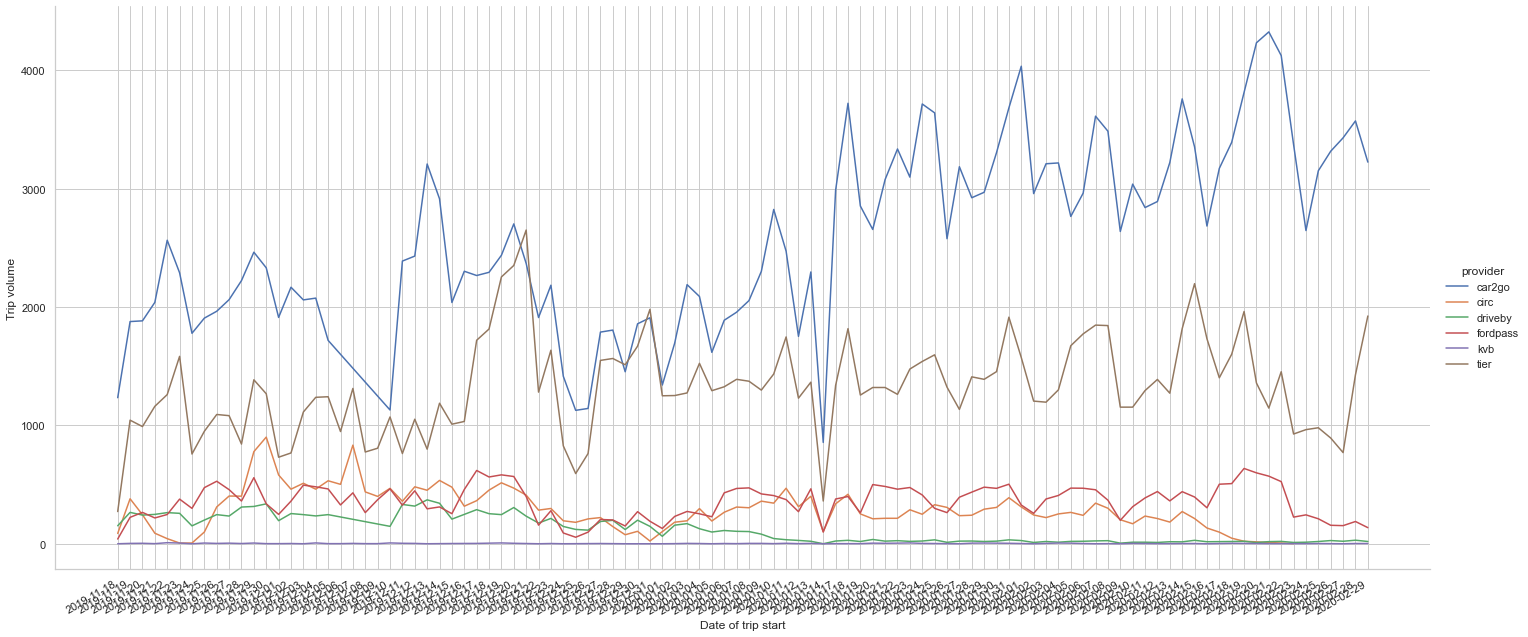

In [27]:
#plot_trip_volume_by_provider_linegraph(show_table)
plot_trip_volume_by_provider_linegraph(False)

In [10]:
df = df[['trip_volume','mode']]
df.head()
#type(data_car['date_start'])
#row1 = pd.Series(['mode', 'c'])
#row2 = pd.Series(['trip_volume', 0])
#row_df1 = pd.DataFrame([row1], index = ["2020-01-15", 1])
#row_df2 = pd.DataFrame([row2], index = ["2020-01-16", 1])

#df = pd.concat([row_df1, row_df2, df])
df.head()

dfa = pd.concat([data_car, data_bicycle, data_scooter])

dfa['provider'].unique()
#dfa.describe()

array(['car2go', 'driveby', 'fordpass', 'kvb', 'tier', 'circ'],
      dtype=object)

##### Linegraph of ratio of trip starts onto hourly time intervals

In [33]:
# convert hour to time interval for visualization
def create_time_interval(data_mode):
    data_mode['hour_next'] = data_mode['hour'].astype(int)+1
    data_mode['Hourly time interval'] = data_mode['hour'].astype(str).str.zfill(2) + ":00 - " + (data_mode['hour_next']).astype(str).str.zfill(2) + ":00"
    #data_mode['Hourly time interval'] = data_mode['hour']
    return data_mode

# prepare data for linegraph plotting
def prepare_data_for_linegraph(data_mode, weekend):
    plot_data = data_mode.copy()
    plot_data = plot_data[plot_data['weekend'] == weekend]
    total_trip_volume_car = len(plot_data)
    plot_data = create_time_interval(plot_data)
    plot_data = plot_data.groupby(['Hourly time interval', 'weekend']).count()
    plot_data['trip_volume'] = plot_data['id']
    ############################################################
    plot_data['utilization'] = plot_data['trip_volume'] / fleet_size_car
    ############################################################
    plot_data['Mode'] = data_mode['vehicleType'].unique()[0]
    plot_data['Ratio of trip starts of total number of trips [%]'] = plot_data['trip_volume'] * 100 / total_trip_volume_car
    # select important variables
    plot_data = plot_data[['Mode', 'trip_volume', 'utilization', 
                           'Ratio of trip starts of total number of trips [%]']]
    return plot_data

# plot linegraph of ratio (of trip starts of total number of trips) in time interval
def plot_hour_interval_linegraph(weekend, show_all_modes):    
    # prepare data for plotting
    plot_data_car = prepare_data_for_linegraph(data_car, weekend)
    plot_data_bicycle = prepare_data_for_linegraph(data_bicycle, weekend)
    plot_data_scooter = prepare_data_for_linegraph(data_scooter, weekend)
    # concatenate data modes
    if (show_all_modes):
        plot_data_full = prepare_data_for_linegraph(data_full, weekend)
        plot_data_full['Mode'] = 'all modes'
        plot_data = pd.concat([plot_data_car, plot_data_bicycle, plot_data_scooter, plot_data_full])
    else:
        plot_data = pd.concat([plot_data_car, plot_data_bicycle, plot_data_scooter])
    # sort values by hour
    plot_data = plot_data.sort_values(['Hourly time interval', 'weekend'])
    # plot linegraph
    g = sns.relplot(x="Hourly time interval", y="Ratio of trip starts of total number of trips [%]", kind="line", 
                    data=plot_data, hue="Mode", height=5, aspect=2)
    # rotate x axis labels
    g.set_xticklabels(rotation=30)
    #print(plot_data.to_string())

                                   Mode  trip_volume  utilization  Ratio of trip starts of total number of trips [%]
Hourly time interval weekend                                                                                        
00:00 - 01:00        0              car         1610     1.150822                                           0.845464
                     0          bicycle          212     0.151537                                           0.757549
                     0          scooter         2223     1.588992                                           1.982839
                     0        all modes         4045     2.891351                                           1.223811
01:00 - 02:00        0              car         1161     0.829878                                           0.609679
                     0          bicycle          103     0.073624                                           0.368054
                     0          scooter         1467     1.04860

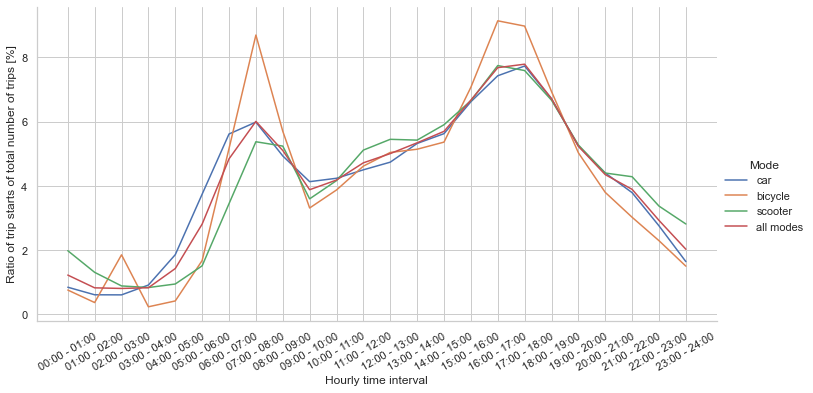

In [34]:
# weekdays (Mondays to Fridays)
# plot linegraph of ratio (of trip starts of total number of trips) in time interval
# set True if all modes is desired
plot_hour_interval_linegraph(0, True)

                                   Mode  trip_volume  utilization  Ratio of trip starts of total number of trips [%]
Hourly time interval weekend                                                                                        
00:00 - 01:00        1              car         1689     1.207291                                           2.276035
                     1          bicycle          302     0.215868                                           3.512853
                     1          scooter         2094     1.496783                                           4.174891
                     1        all modes         4085     2.919943                                           3.072306
01:00 - 02:00        1              car         1088     0.777698                                           1.466149
                     1          bicycle          208     0.148678                                           2.419449
                     1          scooter         1875     1.34024

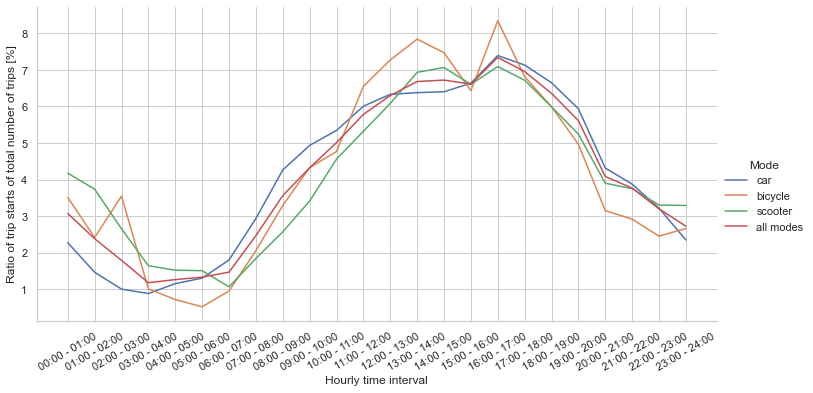

In [35]:
# weekend (Saturdays and Sundays)
# plot linegraph of ratio (of trip starts of total number of trips) in time interval
# set True if all modes is desired
plot_hour_interval_linegraph(1, True)

##### Barplot of ratio of trip starts onto weekdays

In [52]:
# create weekday names for numeric equivalent for dataframe
def create_weekday_name(data_mode):
    data_mode['Weekdays'] = pd.to_datetime(data_mode['date_start'], format='%Y-%m-%d').dt.day_name()
    return data_mode

# prepare data for plotting on weekdays
def prepare_data_for_weekday_barplot(data_mode):
    plot_data = data_mode.copy()
    total_trip_volume = len(plot_data)
    plot_data = create_weekday_name(plot_data)
    # group data by weekday number and weekday names to get trip volume and to calculate the ratio
    plot_data = plot_data.groupby(['weekday', 'Weekdays']).count().reset_index()
    plot_data['trip_volume'] = plot_data['id']
    plot_data['Ratio of trip starts on total number of trips [%]'] = plot_data['trip_volume'] * 100 / total_trip_volume
    plot_data['Mode'] = data_mode['vehicleType'].unique()[0]
    # select important variables
    plot_data = plot_data[['weekday', 'Weekdays', 'Mode', 'Ratio of trip starts on total number of trips [%]']]
    return plot_data

# plot barplot of ratio of trip starts of total number of trips on weekdays
def plot_ratio_trip_starts_on_weekday_barplot(show_all_modes):
    # prepare data for plotting
    plot_data_car = prepare_data_for_weekday_barplot(data_car)
    plot_data_bicycle = prepare_data_for_weekday_barplot(data_bicycle)
    plot_data_scooter = prepare_data_for_weekday_barplot(data_scooter)
    
    # concatenate data modes
    if (show_all_modes):
        plot_data_full = prepare_data_for_weekday_barplot(data_full)
        plot_data_full['Mode'] = 'all modes'
        plot_data = pd.concat([plot_data_car, plot_data_bicycle, plot_data_scooter, plot_data_full])
    else:
        plot_data = pd.concat([plot_data_car, plot_data_bicycle, plot_data_scooter])
      
    # sort by weekday number and weekday names
    plot_data = plot_data.sort_values(['weekday', 'Weekdays'])
    # plot data
    sns.catplot(x="Weekdays", y="Ratio of trip starts on total number of trips [%]", hue="Mode", 
                data=plot_data, kind="bar", height=5, aspect=2)
    # show dataframe
    #print(plot_data.to_string())

   weekday   Weekdays     Mode  Ratio of trip starts on total number of trips [%]
0        0     Monday      car                                          13.335298
0        0     Monday  bicycle                                          15.127658
0        0     Monday  scooter                                          12.568020
1        1    Tuesday      car                                          13.513279
1        1    Tuesday  bicycle                                          15.524028
1        1    Tuesday  scooter                                          13.669894
2        2  Wednesday      car                                          13.621729
2        2  Wednesday  bicycle                                          14.939041
2        2  Wednesday  scooter                                          13.006797
3        3   Thursday      car                                          14.393355
3        3   Thursday  bicycle                                          14.785960
3        3   Thu

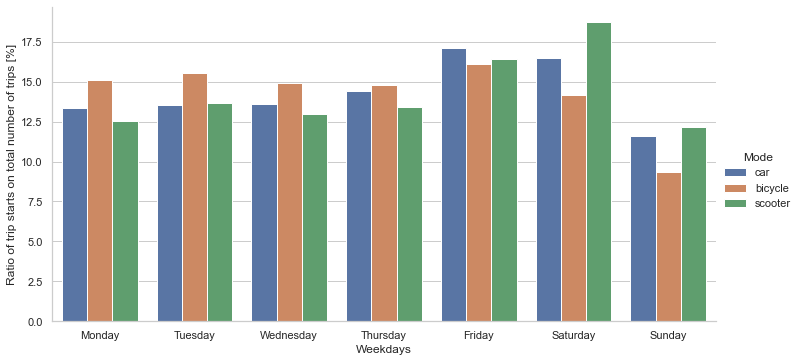

In [53]:
# plot a barplot of ratio (of trip starts on total number of trips) onto weekdays without all modes reference
plot_ratio_trip_starts_on_weekday_barplot(False)

   weekday   Weekdays       Mode  Ratio of trip starts on total number of trips [%]
0        0     Monday        car                                          13.335298
0        0     Monday    bicycle                                          15.127658
0        0     Monday    scooter                                          12.568020
0        0     Monday  all modes                                          13.208137
1        1    Tuesday        car                                          13.513279
1        1    Tuesday    bicycle                                          15.524028
1        1    Tuesday    scooter                                          13.669894
1        1    Tuesday  all modes                                          13.726814
2        2  Wednesday        car                                          13.621729
2        2  Wednesday    bicycle                                          14.939041
2        2  Wednesday    scooter                                          13

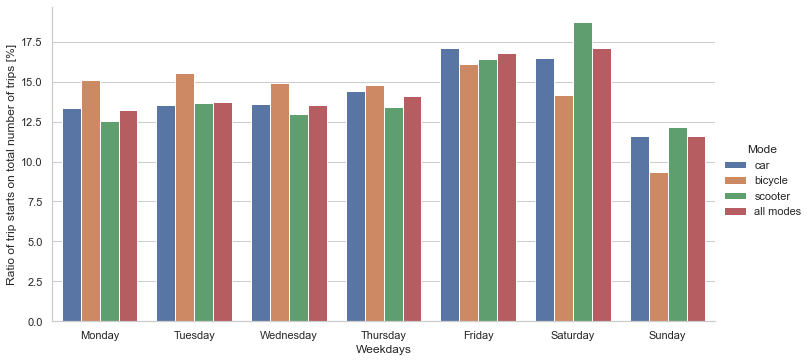

In [45]:
# plot a barplot of ratio (of trip starts on total number of trips) onto weekdays with all modes reference
plot_ratio_trip_starts_on_weekday_barplot(True)

##### Histogram of density of duration

In [ ]:
# plot a duration density histogram of selected mode and binwidth in min
def plot_duration_density_histogram(data_mode, binwidth, kde):
    plot_data = data_mode.copy()
    # calculate duration in min
    plot_data['duration'] = plot_data['duration'] / 60
    plot_data = plot_data.rename(columns={"duration": "Duration [min]"})
    sns.displot(plot_data, x="Duration [min]", binwidth=binwidth, height=5, aspect=2, stat='density', kde=kde)

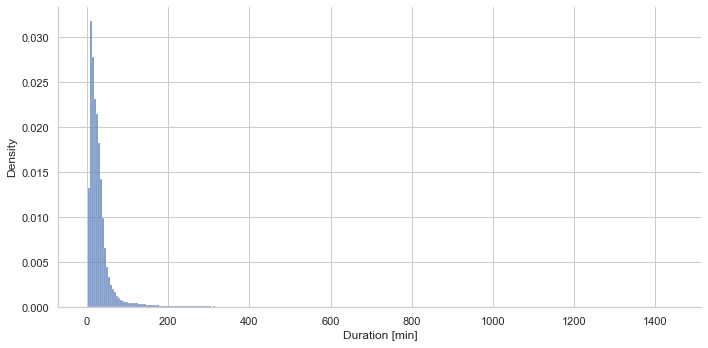

In [17]:
# plot a duration density histogram of all modes data and binwidth in min and kde if desired
plot_duration_density_histogram(data_full, 5, False)

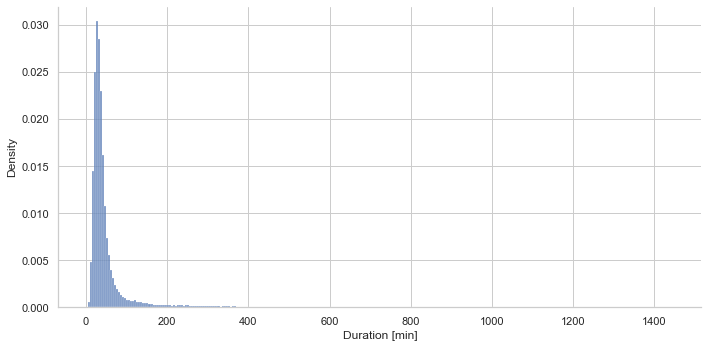

In [18]:
# plot a duration density histogram of car data and binwidth in min and kde if desired
plot_duration_density_histogram(data_car, 5, False)

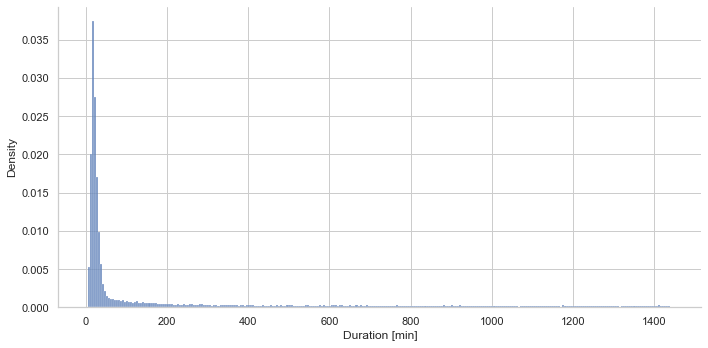

In [19]:
# plot a duration density histogram of bicycle data and binwidth in min and kde if desired
plot_duration_density_histogram(data_bicycle, 5, False)

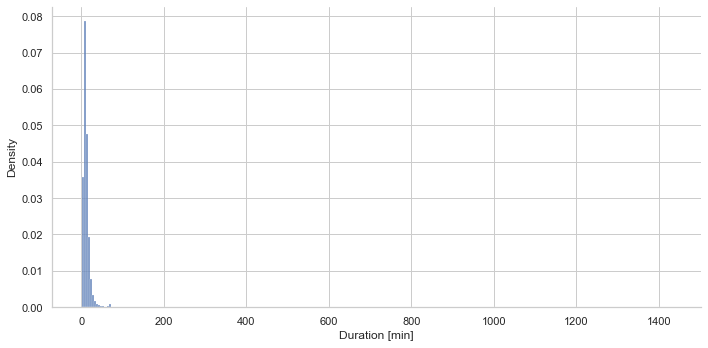

In [20]:
# plot a duration density histogram of scooter data and binwidth in min and kde if desired
plot_duration_density_histogram(data_scooter, 5, False)

# ENDENDENDEND

In [ ]:
peng = pd.concat([data_car, data_bicycle, data_scooter])
peng = peng[['vehicleType', 'time_start', 'duration', 'weekday']] #'longitude_start','latitude_start','longitude_end','latitude_end']]

#g = sns.pairplot(peng, plot_kws=dict(marker="+", linewidth=0.07), diag_kws=dict(fill=False),)
#g.map_lower(sns.kdeplot, levels=3, color=".2")

# plot_kws={"s": 3},
#x_vars=["time_start", "duration", "weekday",'longitude_end','latitude_end' ], y_vars=["time_start", "duration", "weekday", "latitude_start", "latitude_end"]

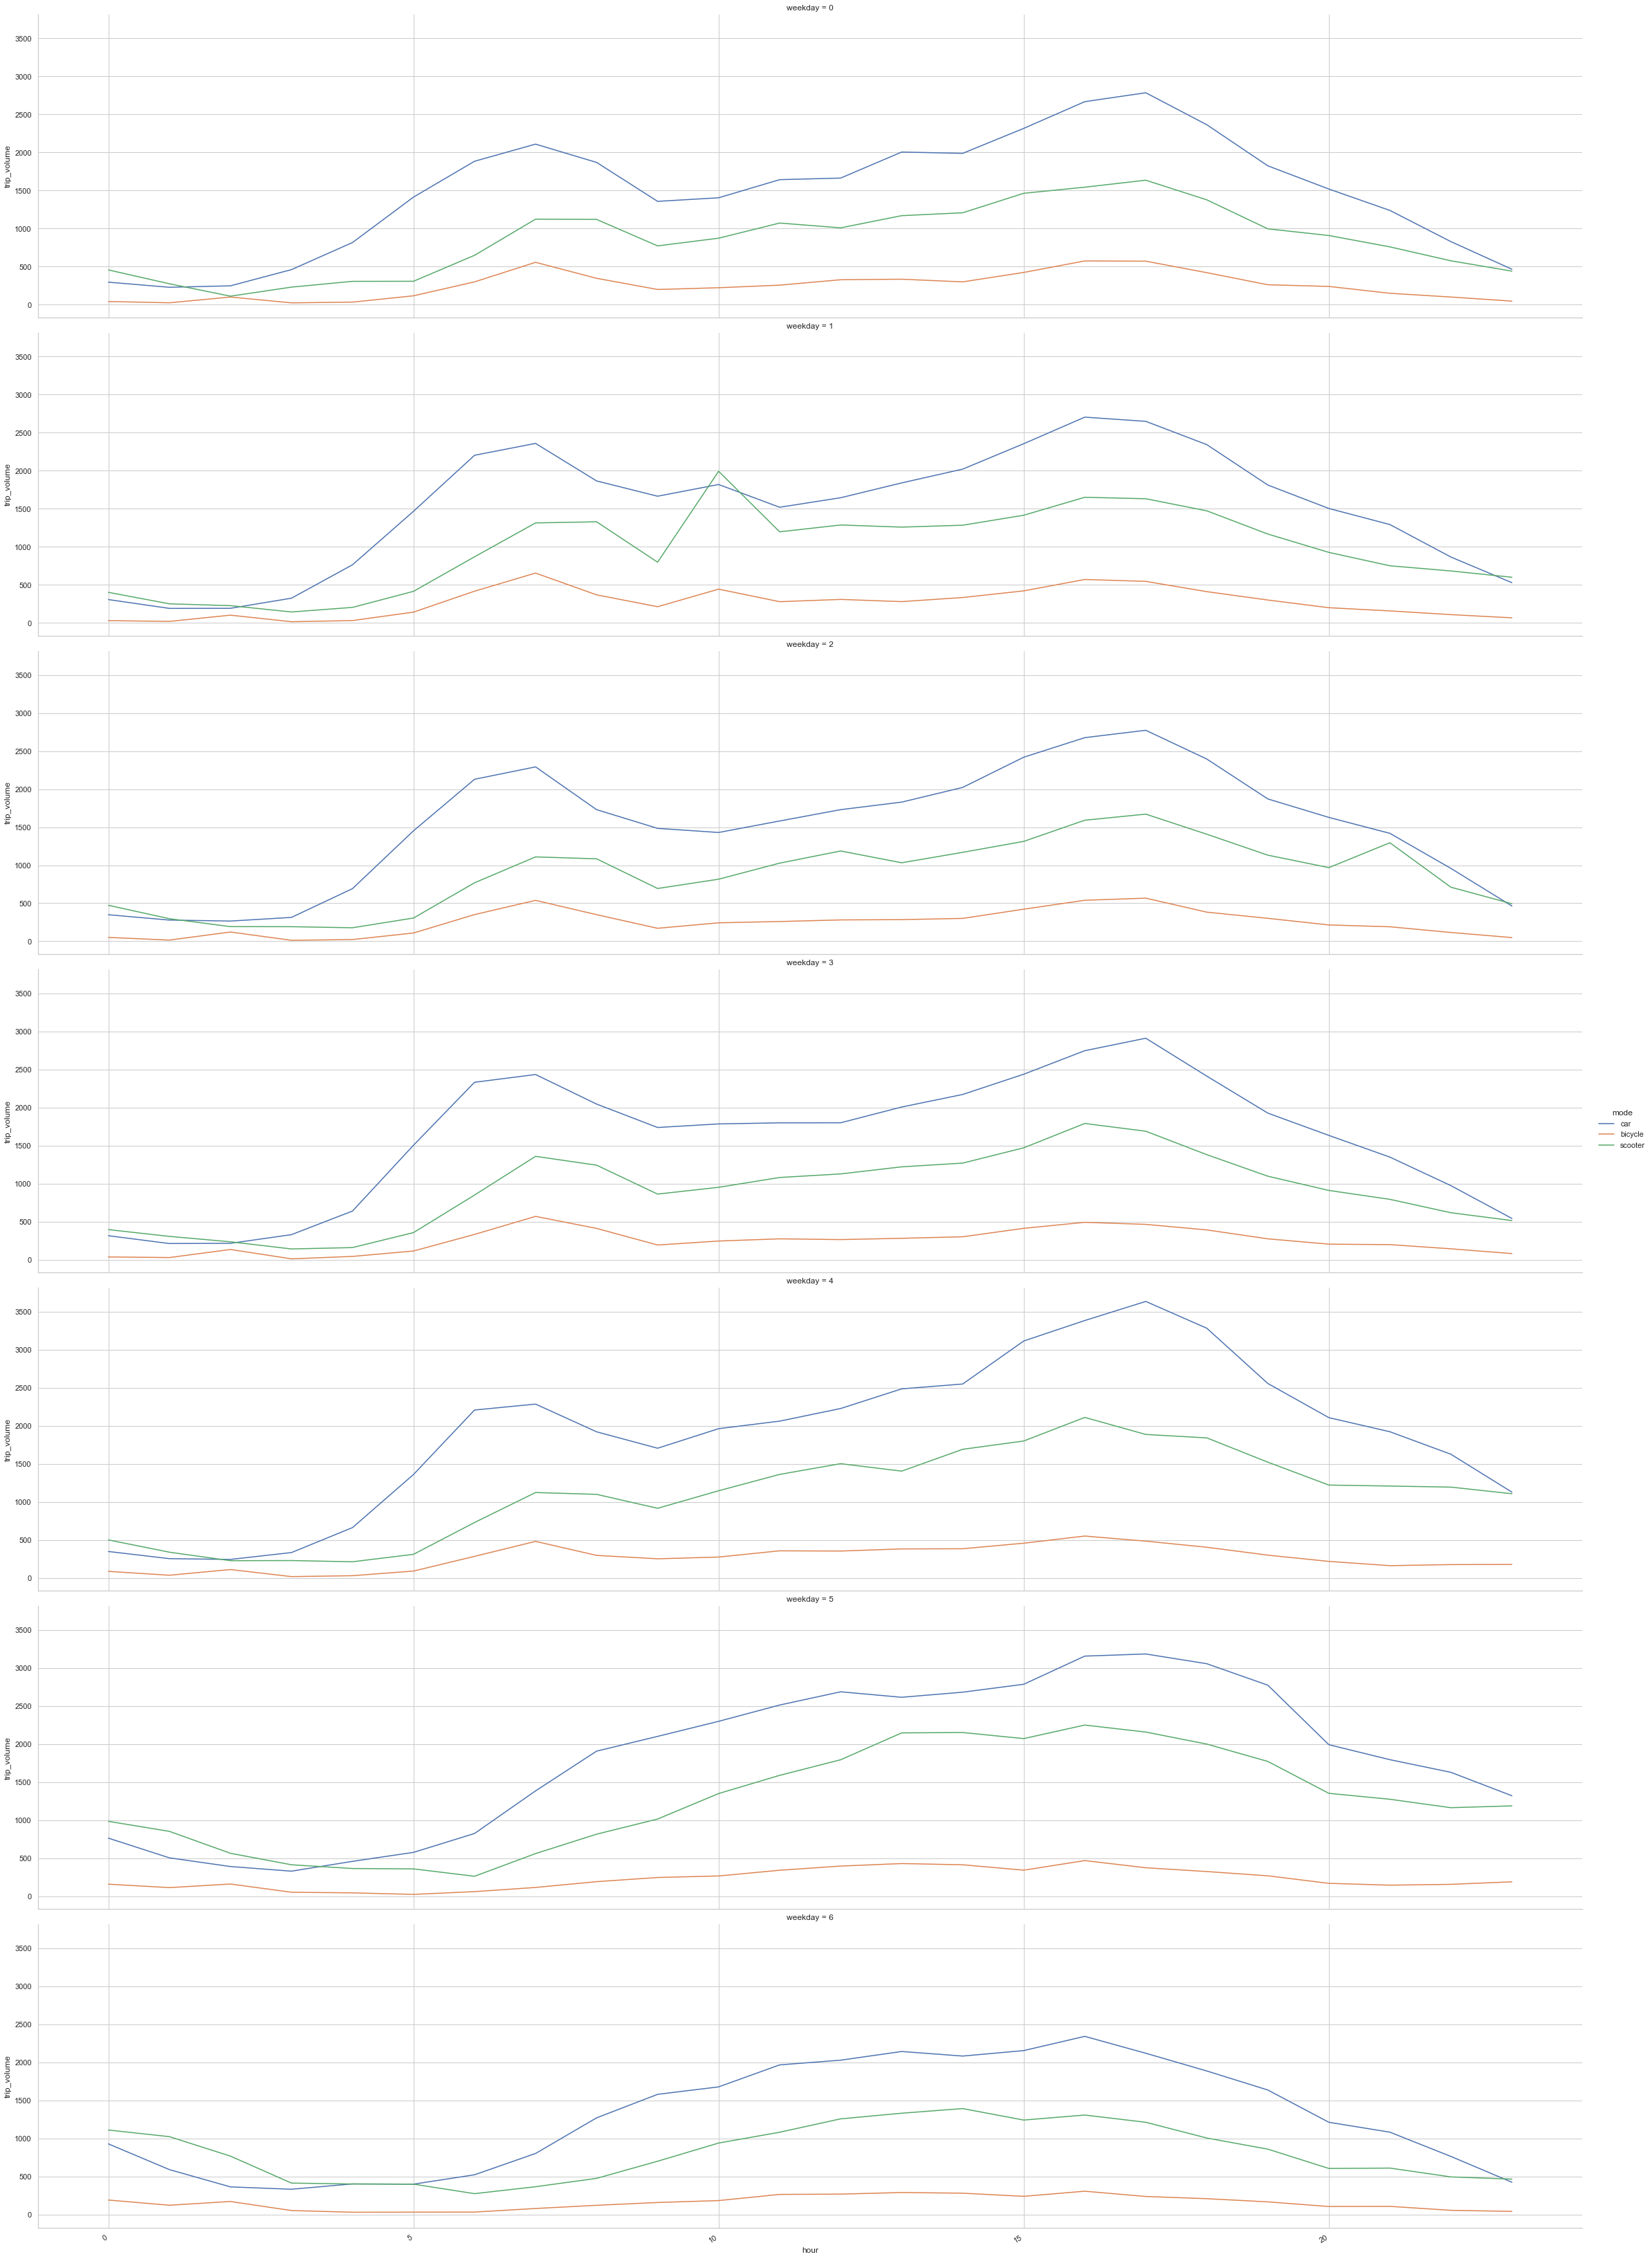

In [24]:
g = sns.relplot(x="hour", y="trip_volume", kind="line", data=df, hue="mode", row='weekday', height=8, aspect=4)
g.fig.autofmt_xdate()

In [7]:
#df.head()
#len(data_car[data_car['weekend']==1])
#len(data_car)

#.dt.strftime('%H00').head()
d = data_car
d['hour_next'] = d['hour'].astype(int)+1
d['hour']= d['hour'].astype(str).str.zfill(2) +":00 - "+ (d['hour_next']).astype(str).str.zfill(2) + ":00"
d['hour'].head()

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


0    13:00 - 1400
1    13:00 - 1400
2    13:00 - 1400
3    13:00 - 1400
4    13:00 - 1400
Name: hour, dtype: object

In [195]:
import folium
from folium import plugins
from folium.plugins import HeatMap


#define new map
hannover_heat_map = folium.Map(location=(50.937, 6.957),  tiles='Stamen Toner', 
                       zoom_start=12, control_scale=True, max_zoom=20)

# add heat map hannover
hannover_heat_map.add_child(plugins.HeatMap(STR_Nov[['latitude_start', 'longitude_start']], radius=11))

In [196]:
STR_Nov_scooter = STR_Nov[STR_Nov["vehicleType"]=="kick scooter"]
#len(STR_Nov_scooter)
STR_Nov_scooter.describe()

,date_start,time_start,date_end,time_end,longitude_start,latitude_start,longitude_end,latitude_end,fuel_start,fuel_end,distance,duration,price_promo_start,price_promo_end,missing_file_number,dist_center_start,dist_center_end,c,Weekday,Hour
count,2058.0,2058.000000,2058.0,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,0.0,0.0,2058.0,2058.000000,2058.000000,2058.0,2058.0,2058.000000
mean,20200229.0,1363.549563,20200229.0,1386.873178,6.951305,50.934892,6.950523,50.935211,69.388727,61.133625,1329.345563,847.840622,NaN,NaN,0.0,2229.334477,2246.305656,10.0,5.0,13.361516
std,0.0,587.396717,0.0,590.394636,0.028987,0.016954,0.029131,0.017175,16.782735,18.475019,1851.921498,640.678345,NaN,NaN,0.0,1880.678210,1897.532230,0.0,0.0,5.877829
min,20200229.0,0.000000,20200229.0,5.000000,6.868793,50.841974,6.869810,50.841974,16.000000,16.000000,50.114060,279.000000,NaN,NaN,0.0,110.565375,110.565375,10.0,5.0,0.000000
25%,20200229.0,1035.000000,20200229.0,1045.000000,6.938646,50.928808,6.937870,50.928858,57.000000,49.000000,506.509203,599.000000,NaN,NaN,0.0,1022.432524,1029.537231,10.0,5.0,10.000000
50%,20200229.0,1420.000000,20200229.0,1435.000000,6.952490,50.936910,6.951639,50.937136,70.000000,62.000000,905.096494,602.000000,NaN,NaN,0.0,1746.858086,1809.104964,10.0,5.0,14.000000
75%,20200229.0,1815.000000,20200229.0,1830.000000,6.963928,50.941677,6.962811,50.941945,82.000000,75.000000,1587.244302,902.000000,NaN,NaN,0.0,3040.111064,3043.331565,10.0,5.0,18.000000
max,20200229.0,2345.000000,20200229.0,2355.000000,7.107601,50.984521,7.107470,50.984521,100.000000,100.000000,16787.563389,11700.000000,NaN,NaN,0.0,15157.902431,15158.676233,10.0,5.0,23.000000


In [197]:
#define empty map

STR_map_points = folium.Map(location=(50.937, 6.957),  tiles='Stamen Toner', 
                       zoom_start=11, control_scale=True, max_zoom=20)


# draw positions for selcted cars

positions = list(STR_Nov_scooter["coordinates_start"].unique())
for position in positions:
    folium.CircleMarker(radius=5, location=position, popup='The Waterfront', 
                                 color='crimson', fill_color='crimson').add_to(STR_map_points)
    
STR_map_points

In [198]:
STR_map_trajectory = folium.Map(location=(50.937, 6.957),  tiles='Stamen Toner', 
                       zoom_start=12, control_scale=True, max_zoom=20)

# draw trajectory for a selected car

folium.PolyLine(STR_Nov_scooter["coordinates_start"],color="blue", weight=1, opacity=0.8, ).add_to(STR_map_trajectory)
STR_map_trajectory

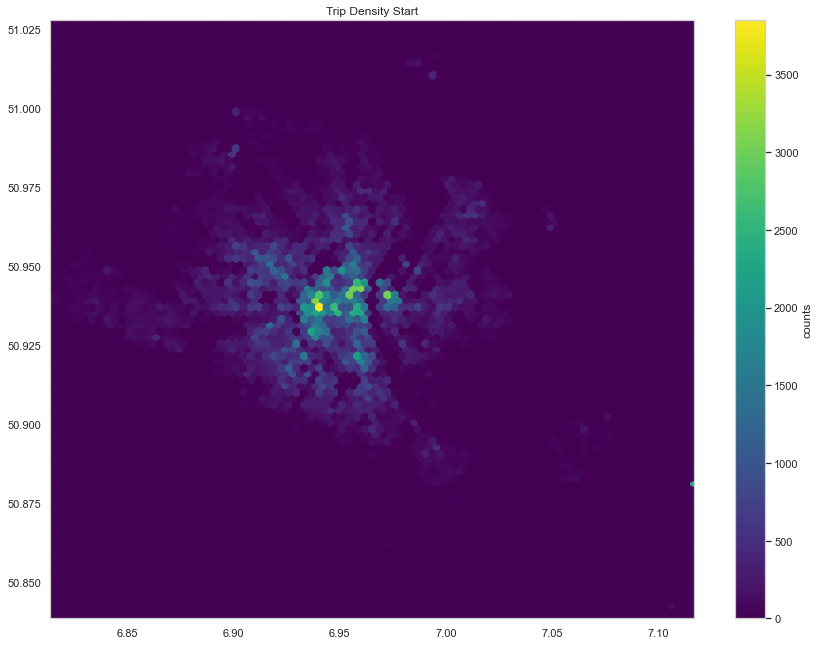

In [88]:
STR_Nov = pd.concat([data_car, data_scooter, data_bicycle])
x = STR_Nov["longitude_start"]
y = STR_Nov["latitude_start"]
xmin = STR_Nov["longitude_start"].min()
xmax = STR_Nov["longitude_start"].max()
ymin = STR_Nov["latitude_start"].min()
ymax = STR_Nov["latitude_start"].max()

fig, axs = plt.subplots(ncols=1, sharey=True, figsize=(13, 11))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs
hb = ax.hexbin(x, y, gridsize=85, cmap='viridis')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Trip Density Start")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')


plt.show()

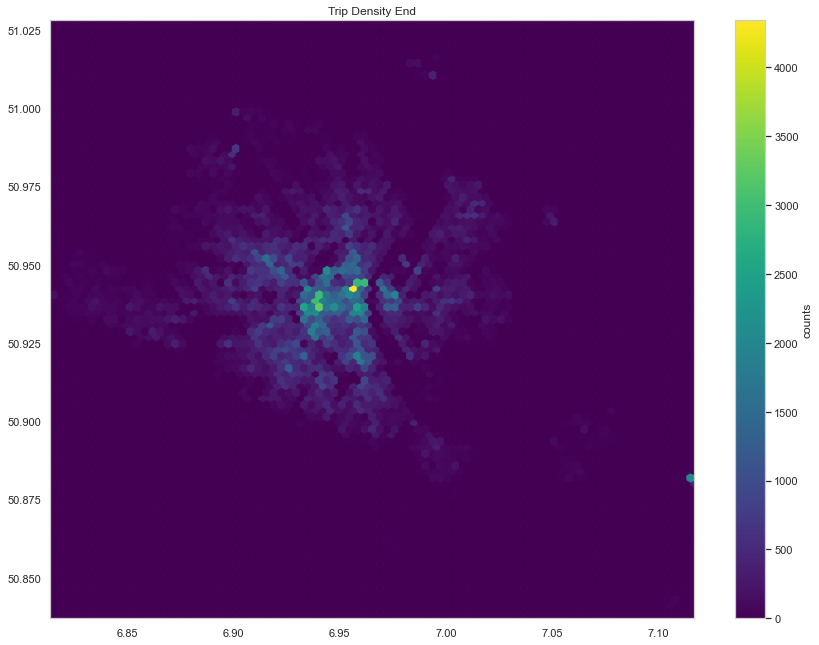

In [89]:
x = STR_Nov["longitude_end"]
y = STR_Nov["latitude_end"]
xmin = STR_Nov["longitude_end"].min()
xmax = STR_Nov["longitude_end"].max()
ymin = STR_Nov["latitude_end"].min()
ymax = STR_Nov["latitude_end"].max()

fig, axs = plt.subplots(ncols=1, sharey=True, figsize=(13, 11))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs
hb = ax.hexbin(x, y, gridsize=85, cmap='viridis')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Trip Density End")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')


plt.show()

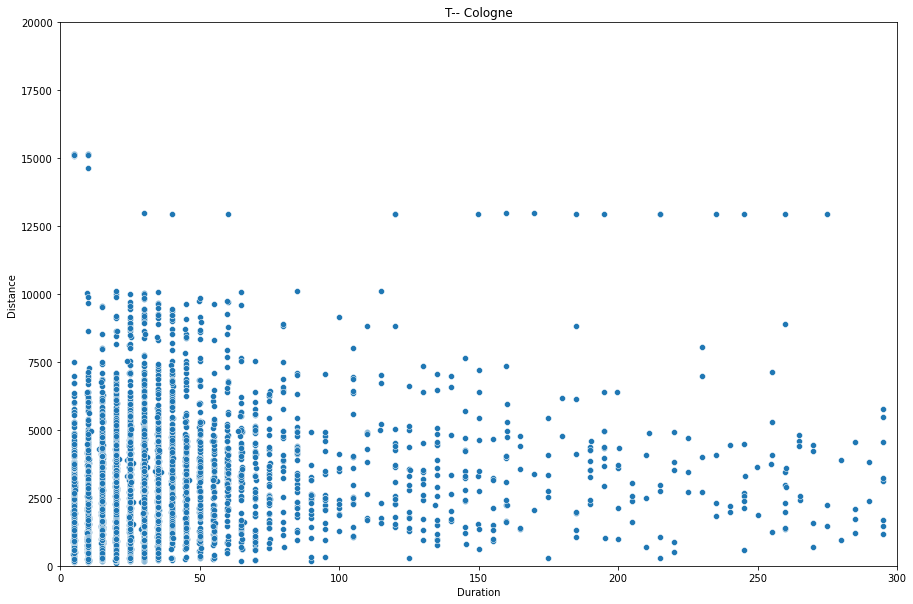

In [203]:
STR_Nov = data_full
def plot_scatter(df, city_name):
    fig, (ax1) = plt.subplots(figsize=(15,10))

    plt.xlim(0, 300)
    plt.ylim(0, 20000)
    sns.scatterplot(x=df["duration"]/60, y=STR_Nov["dist_center_start"], data=df, ax=ax1)
   
    ax1.set(ylabel='Distance', xlabel='Duration')
    ax1.set_title('T-- ' + city_name)
   
    
plot_scatter(STR_Nov, 'Cologne')
#len(STR_Nov_scooter)

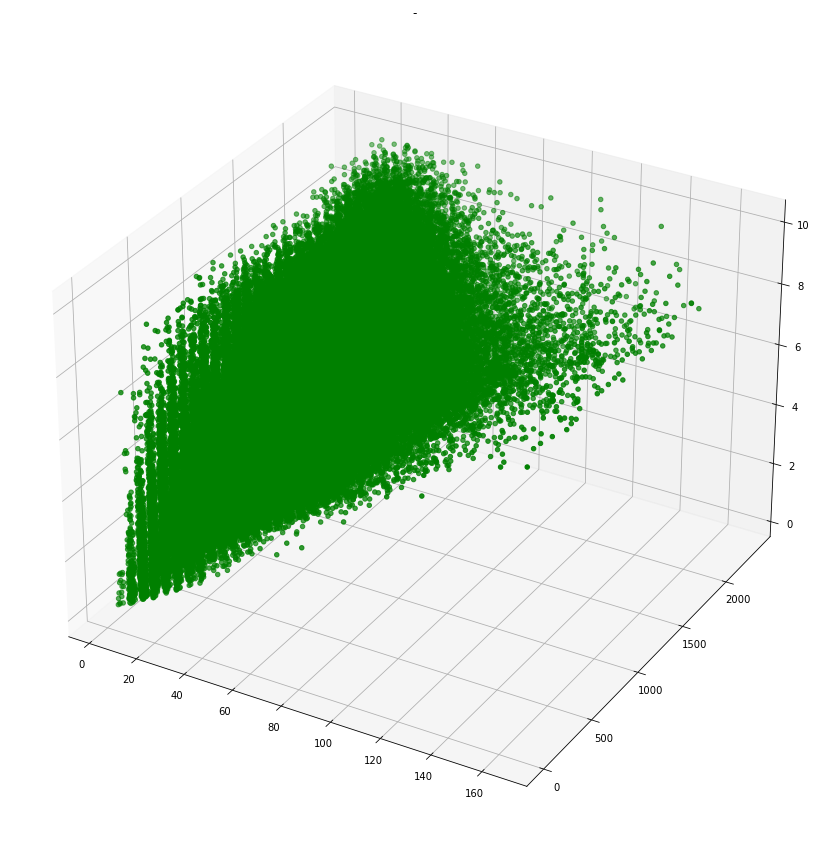

In [16]:
# Import libraries
from mpl_toolkits import mplot3d
 
 
# Creating dataset
#z = (STR_Nov["distance"]/1000)/(STR_Nov["duration"]/60)
#z = STR_Nov["Hour"]
y = data_car['time_start']
x = data_car["duration"]/60
z = data_car["distance"]/1000

#z = STR_Nov["duration"]
#x = STR_Nov["latitude_start"]
#y = STR_Nov["longitude_start"]
 
# Creating figure
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("-")
 
# show plot
plt.show()